In [1]:
!pip uninstall -y deepxde && rm -rf deepxde; git clone https://github.com/ewang729/deepxde.git ; cd deepxde && git config --global user.email "a@a.com" ; git config --global user.name "a"; git checkout loss-scaling ;ls;pip install ./
!pip install matplotlib

Cloning into 'deepxde'...
remote: Enumerating objects: 7485, done.
remote: Total 7485 (delta 0), reused 0 (delta 0), pack-reused 7485
Receiving objects: 100% (7485/7485), 26.57 MiB | 13.29 MiB/s, done.
Resolving deltas: 100% (5391/5391), done.
error: pathspec 'loss-scaling' did not match any file(s) known to git
CITATION.cff  deepxde  docker  docs  examples  LICENSE	pyproject.toml	README.md  requirements.txt
Processing /content/deepxde
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 1.3 MB/s eta 0:00:00
  Created wheel for DeepXDE: filename=DeepXDE-0.1.dev1071+gc98008f-py3-none-any.whl size=157882 sha256=4b1e537177ba4cdc8d4eb72ef097ac9527cb0071a7bd4ae9ace393ad65b1cc2c
  Stored in directory: /tmp/pip-ephem-wheel-cache-mjlwrxoe/wheels/f8/ce/5f/e9ae11a13137aa42b56af26d0ceeb857add65bb7ccf8c2e109
Succes

In [2]:
! apt install cm-super
! sudo apt-get install texlive-latex-recommended
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
! unzip type1cm.zip -d /tmp/type1cm
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
! sudo texhash

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lmodern fonts-noto-mono fonts-urw-base35
  libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libptexenc1
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pfb2t1c2pfb
  poppler-data t1utils tex-common texlive-base texlive-binaries texlive-latex-base
  texlive-latex-recommended xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre poppler-utils ghostscript
  fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper gv | postscript-viewer perl-tk xpdf
  | pdf-viewer xzdec texlive-latex-base-doc texlive-latex-recommended-doc texlive-luatex
  texlive-pstricks
The following NEW

In [3]:
%env DDE_BACKEND=pytorch
import deepxde as dde
import numpy as np
import torch
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')


def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return (
         dy_t
         - dy_xx
         + torch.exp(-x[:, 1:])
         * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
    )


def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])

prev_grad = []
prev_weight = []
cosines = []
gradnorm = []
graddiff = []
wnorm = []
L = [0]
loss_mixed = []
loss_32 = []
scaler = torch.cuda.amp.GradScaler(enabled=True)

def get_grad(model):
    gradient = np.array([])
    for layer in model.net.linears:
        gradient = np.concatenate([gradient, layer.weight.grad.flatten().cpu().numpy()])
    return gradient

def get_weight(model):
    weights = np.array([])
    for layer in model.net.linears:
        weights = np.concatenate([weights, layer.weight.flatten().detach().cpu().numpy()])
    return weights

# calculation of both float32 and mixed gradients
def train_step_slow(model, inputs, targets):
    global prev_grad
    global prev_weight

    losses = model.outputs_losses_train(inputs, targets)[1]
    total_loss = torch.sum(losses)
    total_loss.backward()
    g2 = get_grad(model)
    model.opt.zero_grad()

    with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=True):
        losses = model.outputs_losses_train(inputs, targets)[1]
        total_loss = torch.sum(losses)
    scaler.scale(total_loss).backward()
    scaler.unscale_(model.opt)
    g1 = get_grad(model)
    scaler.step(model.opt)
    scaler.update()
    model.opt.zero_grad()

    cosines.append(np.dot(g1, g2)/(np.linalg.norm(g1)*np.linalg.norm(g2)))
    gradnorm.append(np.linalg.norm(g2))
    w = get_weight(model)
    wnorm.append(np.linalg.norm(w))
    graddiff.append(np.linalg.norm(g1 - g2))
    if(model.train_state.step != 0):
        L.append(np.linalg.norm(prev_grad - g2)/np.linalg.norm(prev_weight - w))
    prev_grad = g2
    prev_weight = w

# calculation of only float32 gradient
def train_step_fast(model, inputs, targets):
    losses = model.outputs_losses_train(inputs, targets)[1]
    total_loss = torch.sum(losses)
    total_loss.backward()
    model.opt.step()
    model.opt.zero_grad()

def train(model, iterations, display_every, train_step, loss):
    for i in range(iterations):
        model.train_state.set_data_train(
            *model.data.train_next_batch(model.batch_size)
        )
        train_step(
            model,
            model.train_state.X_train,
            model.train_state.y_train,
        )
        model.train_state.epoch += 1
        model.train_state.step += 1
        if model.train_state.step % display_every == 0 or i + 1 == iterations:
            print(model.train_state.step)

        X_test, y_test, _ = model.data.test()
        y_pred = model.predict(X_test)
        l2r = np.linalg.norm(y_pred - y_test) / np.linalg.norm(y_test)
        loss.append(l2r)

def test(amp, dde_precision, seed, size = 32, iter = 3500):
    dde.config.set_default_float(dde_precision)
    dde.config.set_random_seed(seed)
    geom = dde.geometry.Interval(-1, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    data = dde.data.TimePDE(geomtime, pde, [], num_domain=500, solution=func, num_test=10000)

    layer_size = [2] + [size] * 3 + [1]
    activation = "tanh"
    initializer = "Glorot uniform"
    net = dde.nn.FNN(layer_size, activation, initializer)
    net.apply_output_transform(
        lambda x, y: x[:, 1:2] * (1 - x[:, 0:1] ** 2) * y + torch.sin(np.pi * x[:, 0:1])
    )

    model = dde.Model(data, net)

    model.compile("adam", lr=0.001, metrics=["l2 relative error"], amp=amp)
    train(model, iter, 500, train_step_slow, loss_mixed)
    dde.config.set_random_seed(seed)
    dde.config.set_random_seed(seed)
    geom = dde.geometry.Interval(-1, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    data = dde.data.TimePDE(geomtime, pde, [], num_domain=500, solution=func, num_test=10000)

    layer_size = [2] + [size] * 3 + [1]
    activation = "tanh"
    initializer = "Glorot uniform"
    net = dde.nn.FNN(layer_size, activation, initializer)
    net.apply_output_transform(
        lambda x, y: x[:, 1:2] * (1 - x[:, 0:1] ** 2) * y + torch.sin(np.pi * x[:, 0:1])
    )

    model = dde.Model(data, net)
    model.compile("adam", lr=0.001, metrics=["l2 relative error"], amp=amp)
    train(model, iter, 500, train_step_fast, loss_32)
    print("float32:")
    print(min(loss_32))
    print("mixed: ")
    print(min(loss_mixed))

    x = [i for i in range(len(cosines))]
    cosines2 = [1 - r for r in cosines]
    gradoverL = [g/l for g, l in zip(gradnorm, L)]
    alpha = 0.00048828125
    ub = [2*alpha*w/(g/(l) + alpha*w) for g, l, w in zip(gradnorm, L, wnorm)]
    gradrel = [d/g for d, g in zip(graddiff, gradnorm)]
    print(graddiff)
    print(gradnorm)
    ubr = [l*alpha*w/g for l, w, g in zip(L, wnorm, gradnorm)]

env: DDE_BACKEND=pytorch


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/usr/local/lib/python3.10/dist-packages/torch/__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


In [4]:
test(True, "float32", 0, 32, 2000)

Set the default float type to float32
Compiling model...
'compile' took 4.014382 s



<ipython-input-3-b48df7f149a7>:68: RuntimeWarning: invalid value encountered in scalar divide
  cosines.append(np.dot(g1, g2)/(np.linalg.norm(g1)*np.linalg.norm(g2)))
<ipython-input-3-b48df7f149a7>:74: RuntimeWarning: divide by zero encountered in scalar divide
  L.append(np.linalg.norm(prev_grad - g2)/np.linalg.norm(prev_weight - w))
<ipython-input-3-b48df7f149a7>:74: RuntimeWarning: invalid value encountered in scalar divide
  L.append(np.linalg.norm(prev_grad - g2)/np.linalg.norm(prev_weight - w))


500
1000
1500
2000
Compiling model...
'compile' took 0.000374 s

500
1000
1500
2000
float32:
0.0011254721
mixed: 
0.0011074116
[inf, inf, inf, 0.014612004207177056, 0.013539821282002956, 0.011729137414505403, 0.011000784367429536, 0.01042838287394208, 0.006680465902833367, 0.008425714689064135, 0.005842523675163909, 0.004695558638170036, 0.0041861372243471515, 0.006806927509233745, 0.009501159301329895, 0.00513669802976124, 0.0021558783753461482, 0.009124964046492942, 0.003930105470969526, 0.0039917371809343166, 0.008486421029181427, 0.00880331699248456, 0.009303592656967187, 0.004282965485976577, 0.009066755928139783, 0.004441046093931858, 0.004329695014266848, 0.009247749866037793, 0.006661535526916602, 0.011848674002472404, 0.004132244607977689, 0.0024808079235824356, 0.004453937685287043, 0.00678427218045324, 0.00903505868916257, 0.0022228342135044883, 0.003616963556615062, 0.0035360854993762353, 0.006881457150936369, 0.002943492571755379, 0.009352025476080578, 0.004056083161010136

<ipython-input-3-b48df7f149a7>:153: RuntimeWarning: divide by zero encountered in scalar divide
  gradoverL = [g/l for g, l in zip(gradnorm, L)]
<ipython-input-3-b48df7f149a7>:155: RuntimeWarning: divide by zero encountered in scalar divide
  ub = [2*alpha*w/(g/(l) + alpha*w) for g, l, w in zip(gradnorm, L, wnorm)]


<Figure size 640x480 with 0 Axes>

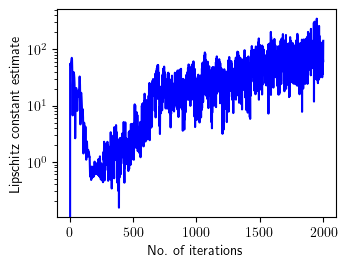

In [5]:
x = range(len(L))
lip_global = max(L[100:])
lg = [lip_global]*len(x)
lip_local = [max(L[max(i-100, 0) : min(i + 100, len(L))]) for i in range(len(L))]
plt.clf()
plt.figure(figsize=(3.6,2.7))
plt.xlabel('No. of iterations')
plt.ylabel('Lipschitz constant estimate')
plt.plot(x, L, label = "Lipschitz constant estimate", color = 'blue')
# plt.plot(x, lg, label = 'Global Lipschitz constant', color = 'black', linestyle='dashed')
# plt.plot(x, lip_local, label = 'Local Lipschitz constant', color = 'green')
plt.yscale('log')
#leg = plt.legend(loc='upper center', frameon = False)
plt.savefig("lipschitz-constant.pdf", bbox_inches='tight')
plt.show()

<ipython-input-7-4bc92c3e8702>:12: RuntimeWarning: divide by zero encountered in scalar divide
  gradoverL = [g/l for g, l in zip(gradnorm, L)]
<ipython-input-7-4bc92c3e8702>:19: RuntimeWarning: divide by zero encountered in scalar divide
  factor = [g/(w*l) for g, w, l in zip(gradnorm, wnorm, L)]


<Figure size 640x480 with 0 Axes>

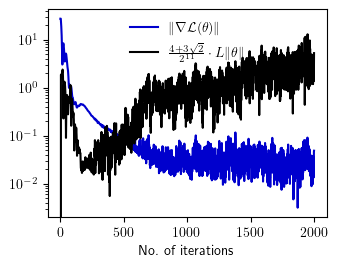

In [7]:
#@title testing Theorem 1

#import matplotlib
#matplotlib.rcParams['text.usetex'] = True

#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

x = range(len(cosines))
zero = [0] * len(cosines)
cosines2 = [1 - r for r in cosines]
gradoverL = [g/l for g, l in zip(gradnorm, L)]
a = 0.00402472689
gradrel = [d/g for d, g in zip(graddiff, gradnorm)]
trueL = L[0:100]
for i in range(100, len(L)):
    trueL.append(max(trueL[-1], L[i]))
crit = [a for l in trueL]
factor = [g/(w*l) for g, w, l in zip(gradnorm, wnorm, L)]
crit2 = [a*w*l for w, l in zip(wnorm, L)]

plt.clf()
plt.figure(figsize=(3.6,2.7))
plt.xlabel('No. of iterations')
#plt.plot(x, L, label = "Lipschitz constant estimate", color = 'mediumblue')
plt.plot(x, gradnorm, label = r"$\lVert \nabla \mathcal{L} (\theta) \rVert$", color = 'mediumblue')
plt.plot(x, crit2, label = r'$\frac{4+3\sqrt{2}}{2^{11}}\cdot L \lVert \theta \rVert$', color = 'black')
#plt.fill_between(x, crit2, zero, color = 'black', alpha = 0.3)

plt.yscale('log')
leg = plt.legend(loc='upper center', frameon = False)
plt.savefig("bound-test-ii.pdf", bbox_inches='tight')
plt.show()